Start by importing some standard libraries for processing, as well as folium. We also verify that we have the right version.

In [3]:
import os
import numpy as np
import pandas as pd
import json
import folium
from branca.colormap import linear
folium.__version__ == '0.5.0'
pd.options.mode.chained_assignment = None  # default='warn'

## Task 1:

Go to the [eurostat](http://ec.europa.eu/eurostat/data/database) website and try to find a dataset that includes the european unemployment rates at a recent date.

Use this data to build a [Choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) which shows the unemployment rate in Europe at a country level. Think about [the colors you use](https://carto.com/academy/courses/intermediate-design/choose-colors-1/), how you decided to [split the intervals](http://gisgeography.com/choropleth-maps-data-classification/) into data classes or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.


## Task 2:

Go to the [amstat](https://www.amstat.ch) website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

> *HINT* Go to the `details` tab to find the raw data you need. If you do not speak French, German or Italian, think of using free translation services to navigate your way through. 

Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.


## Task 3:

Use the [amstat](https://www.amstat.ch) website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between *Swiss* and *foreign* workers.

The Economic Secretary (SECO) releases [a monthly report](https://www.seco.admin.ch/seco/fr/home/Arbeit/Arbeitslosenversicherung/arbeitslosenzahlen.html) on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for *foreign* (`5.1%`) and *Swiss* (`2.2%`) workers. 

Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (*hint* The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.

**Step 1:** Read the data from the CSV

In [92]:
df=pd.read_csv('../rate_Canton_Nationality')
df.dtypes
df=df.drop(52)
df.head()

,Index,region,Canton,Nationality,Unemploy_rate,Unemploy_rate_Young,Registered_unemployed,Young_Unemployed,Long_period_unemployed,Job_seekers,Job_seekers_Employed
0,0,Suisse alémanique,Zurich,Etrangers,5.3,5.8,12111,1015,2106,15384,3273
1,1,Suisse alémanique,Zurich,Suisses,2.5,3.2,15114,2405,2647,18772,3658
2,2,Suisse alémanique,Berne,Etrangers,5.5,7.7,4900,597,848,6859,1959
3,3,Suisse alémanique,Berne,Suisses,1.8,2.2,8758,1406,1488,11526,2768
4,4,Suisse alémanique,Lucerne,Etrangers,3.9,4.7,1593,217,181,2902,1309


In order to plot maps, we need some setup:

In [138]:
init_coords =[46.819, 8.223]
cantons_geo_path = r'ch-cantons.topojson.json'
geo_json_data = json.load(open(cantons_geo_path))

dic=dict(geo_json_data)
liste =dic['objects']['cantons']['geometries']
identification = []
for d in liste:
    identification.append(d['id'])

**Step 2:** We plot the choropleth for unemployment rates of Swiss nationals

In [139]:
df_swissmap = df[df.Nationality != "Etrangers"]
df_swissmap.head()

suisses_map = folium.Map(location=init_coords, tiles='cartodbpositron', zoom_start=7)



df_swissmap['id']=identification

swiss_dict = df_swissmap.set_index('id')['Unemploy_rate']


colormap = linear.OrRd.scale(0,df_swissmap.Unemploy_rate.max())

folium.TopoJson(open('ch-cantons.topojson.json'),
                'objects.cantons',
                style_function=lambda feature: {
                    'fillColor': colormap(swiss_dict[feature['id']]),
                    'color': 'black',
                    'weight': 1,
                    'dashArray': '5, 5',
                    'fillOpacity': 0.8,
                },name='Unemployement rates'
               ).add_to(suisses_map)

colormap.caption = 'Unemployement rates of Swiss people in Switzerland (%)'
colormap.add_to(suisses_map)
suisses_map



**Step 3:** We plot the choropleth for unemployment rates of foreign nationals

In [140]:
df_foreignermap = df[df.Nationality != "Suisses"]
df_foreignermap.head()

etranger_map = folium.Map(location=init_coords, tiles='cartodbpositron', zoom_start=7)

df_foreignermap['id']=identification

etranger_dict = df_foreignermap.set_index('id')['Unemploy_rate']


colormap_f = linear.OrRd.scale(0,df_foreignermap.Unemploy_rate.max())

folium.TopoJson(open('ch-cantons.topojson.json'),
                'objects.cantons',
                style_function=lambda feature: {
                    'fillColor': colormap_f(etranger_dict[feature['id']]),
                    'color': 'black',
                    'weight': 1,
                    'dashArray': '5, 5',
                    'fillOpacity': 0.8,
                },name='Unemployement rates'
               ).add_to(etranger_map)

colormap_f.caption = 'Unemployement rates of Foreigners in Switzerland (%)'
colormap_f.add_to(etranger_map)
etranger_map



**Step 4:** We plot the choropleth for showing the difference between Swiss and Foreign unemployment rates

In [170]:
df1 = df.copy()
df1['diffs'] = df1.groupby(['Canton'])['Unemploy_rate'].diff()
df1.sort_index(inplace=True)
df1.head(20)

df_diffmap = df1[np.isfinite(df1['diffs'])]
df_diffmap['unemployment_diff'] = 0
df_diffmap['unemployment_diff'][(df_diffmap['Nationality'] == 'Etrangers')] = -1*df_diffmap['diffs']
df_diffmap['unemployment_diff'][(df_diffmap['Nationality'] == 'Suisses')] = df_diffmap['diffs']
df_diffmap.head()

diff_map = folium.Map(location=init_coords, tiles='cartodbpositron', zoom_start=7)
df_diffmap['id']=identification
diff_dict = df_diffmap.set_index('id')['unemployment_diff']
x = max(abs(df_diffmap.unemployment_diff.min()),abs(df_diffmap.unemployment_diff.max()))

colormap_d = linear.RdBu.scale(-x,x)
folium.TopoJson(open('ch-cantons.topojson.json'),
                'objects.cantons',
                style_function=lambda feature: {
                    'fillColor': colormap_d(diff_dict[feature['id']]),
                    'color': 'black',
                    'weight': 1,
                    'dashArray': '5, 5',
                    'fillOpacity': 0.8,
                },name='Unemployement rates'
               ).add_to(diff_map)

colormap_d.caption = 'Difference in unemployment rates of Foreigners and Swiss people in Switzerland (%)'
colormap_d.add_to(diff_map)
diff_map

**Step 5:** Now we look at the breakdown by age

In [97]:
#importing libaries and setting style
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('cubehelix',26)

def clean(x):
    if x =="...":
        return float(0)
    else:
        return float(x)

dfx=pd.read_csv('../rate_Canton_Age.csv')
dfx.dtypes
dfx = dfx.drop(260)
df_age = dfx.drop(['Unnamed: 0','Unemployement_Rate_young', 'Registered_unemployed','Unemployed_Young','Unemployed_Long_Period','Job_seekers','Job_seekers_Employed','Region'], axis=1)
df_age['Unemployement_Rate']=df_age['Unemployement_Rate'].apply(lambda x : clean(x))
df_age.head()

,Canton,Age_Category,Unemployement_Rate
0,Zurich,15-19 ans,3.9
1,Zurich,20-24 ans,3.7
2,Zurich,25-29 ans,3.5
3,Zurich,30-34 ans,3.7
4,Zurich,35-39 ans,3.8


In [98]:
df_pivoted_age = df_age.reset_index().pivot(index='Age_Category', columns='Canton', values='Unemployement_Rate')
df_pivoted_age

Canton,Appenzell Rhodes-Extérieures,Appenzell Rhodes-Intérieures,Argovie,Berne,Bâle-Campagne,Bâle-Ville,Fribourg,Genève,Glaris,Grisons,...,Schwyz,Soleure,St-Gall,Tessin,Thurgovie,Uri,Valais,Vaud,Zoug,Zurich
Age_Category,,,,,,,,,,,,,,,,,,,,,
15-19 ans,0.6,0.0,2.2,2.2,1.7,5.4,2.2,2.2,1.2,1.0,...,1.3,2.6,2.0,4.7,2.0,0.4,2.5,2.4,1.4,3.9
20-24 ans,2.0,1.6,3.9,3.1,3.9,4.1,3.7,5.4,2.2,1.6,...,1.7,3.1,2.6,5.4,2.5,0.6,3.8,5.1,2.1,3.7
25-29 ans,2.3,0.4,3.6,3.0,3.6,3.8,3.2,7.2,2.2,1.3,...,1.4,3.0,2.8,3.7,2.7,0.8,3.5,5.5,2.3,3.5
30-34 ans,1.7,0.0,3.4,2.9,3.6,4.2,3.2,6.6,2.0,1.2,...,1.7,3.4,2.5,3.6,2.2,0.6,3.2,5.3,2.6,3.7
35-39 ans,1.6,0.0,3.2,2.8,3.0,3.7,2.9,5.9,1.5,1.2,...,1.4,2.6,2.4,2.7,2.3,0.5,3.1,4.7,2.4,3.8
40-44 ans,1.5,0.2,2.5,2.0,2.3,3.7,2.3,5.2,1.6,0.7,...,1.7,2.0,1.9,2.4,1.6,0.3,2.3,4.1,2.4,3.2
45-49 ans,1.5,0.4,2.3,2.0,2.2,2.8,2.0,4.4,1.5,0.8,...,1.6,1.9,1.5,2.3,1.4,0.6,2.2,3.8,2.1,2.9
50-54 ans,1.9,0.5,2.7,2.1,2.2,2.8,2.7,4.4,1.7,1.0,...,1.6,2.3,1.9,2.9,1.7,0.6,2.4,3.9,2.6,3.1
55-59 ans,1.9,0.0,2.8,2.2,2.7,3.0,2.4,4.0,2.3,1.0,...,2.3,2.8,2.2,3.3,2.1,0.9,2.5,3.9,2.3,3.2


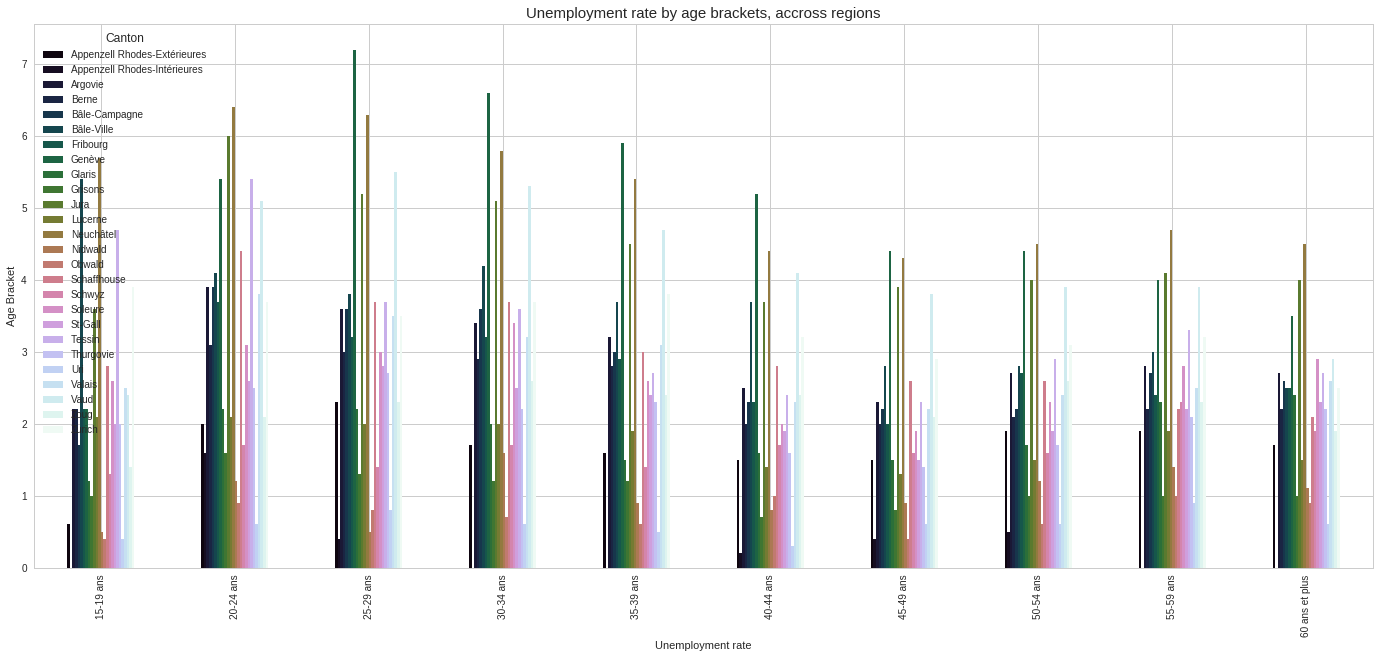

In [99]:
#Plotting and adding info
df_pivoted_age.plot.bar(figsize=(24,10))

plt.title('Unemployment rate by age brackets, accross regions',fontsize=15)
plt.ylabel('Age Bracket')
plt.xlabel('Unemployment rate')
plt.show()

In [100]:
df_pivoted_age = df_age.reset_index().pivot(index='Canton', columns='Age_Category', values='Unemployement_Rate')
df_pivoted_age

Age_Category,15-19 ans,20-24 ans,25-29 ans,30-34 ans,35-39 ans,40-44 ans,45-49 ans,50-54 ans,55-59 ans,60 ans et plus
Canton,,,,,,,,,,
Appenzell Rhodes-Extérieures,0.6,2.0,2.3,1.7,1.6,1.5,1.5,1.9,1.9,1.7
Appenzell Rhodes-Intérieures,0.0,1.6,0.4,0.0,0.0,0.2,0.4,0.5,0.0,0.0
Argovie,2.2,3.9,3.6,3.4,3.2,2.5,2.3,2.7,2.8,2.7
Berne,2.2,3.1,3.0,2.9,2.8,2.0,2.0,2.1,2.2,2.2
Bâle-Campagne,1.7,3.9,3.6,3.6,3.0,2.3,2.2,2.2,2.7,2.6
Bâle-Ville,5.4,4.1,3.8,4.2,3.7,3.7,2.8,2.8,3.0,2.5
Fribourg,2.2,3.7,3.2,3.2,2.9,2.3,2.0,2.7,2.4,2.5
Genève,2.2,5.4,7.2,6.6,5.9,5.2,4.4,4.4,4.0,3.5
Glaris,1.2,2.2,2.2,2.0,1.5,1.6,1.5,1.7,2.3,2.4


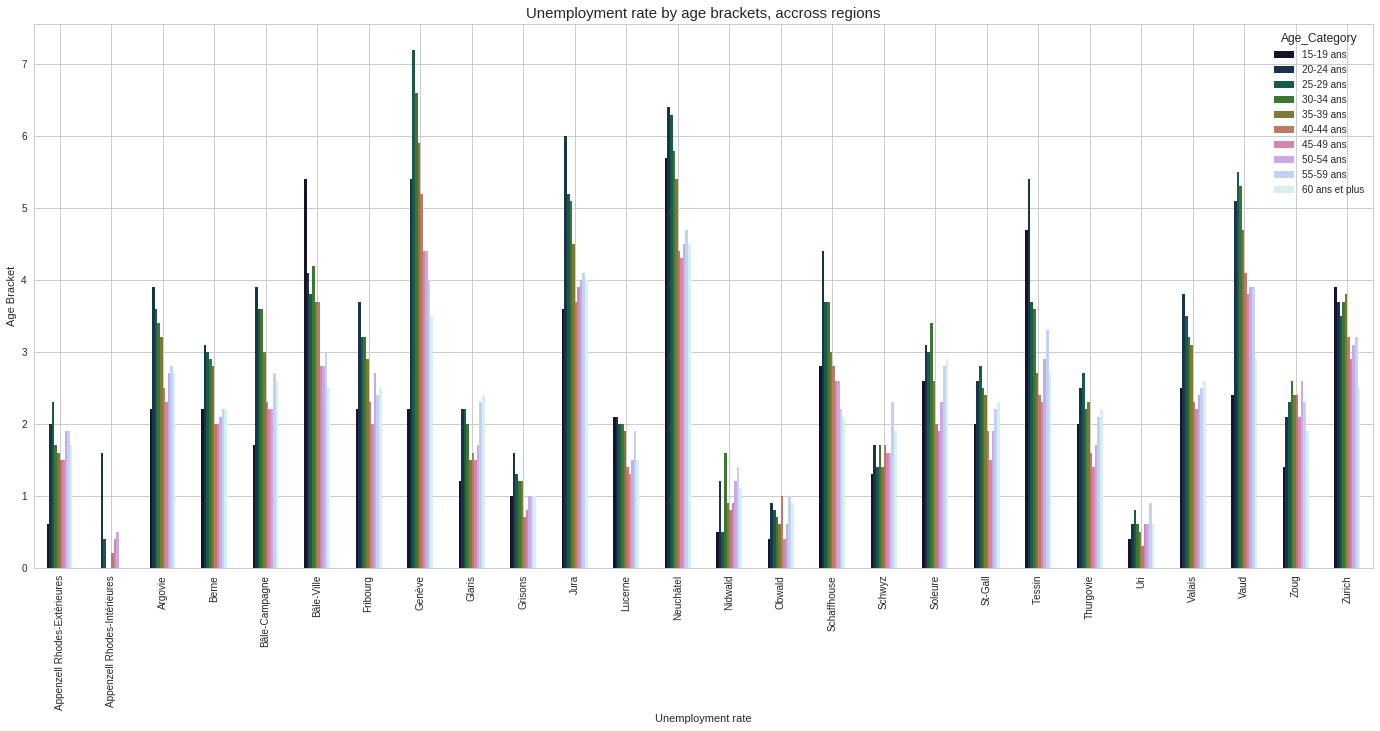

In [101]:
#Plotting and adding info
sns.set_palette('cubehelix',10)
df_pivoted_age.plot.bar(figsize=(24,10))

plt.title('Unemployment rate by age brackets, accross regions',fontsize=15)
plt.ylabel('Age Bracket')
plt.xlabel('Unemployment rate')
plt.show()

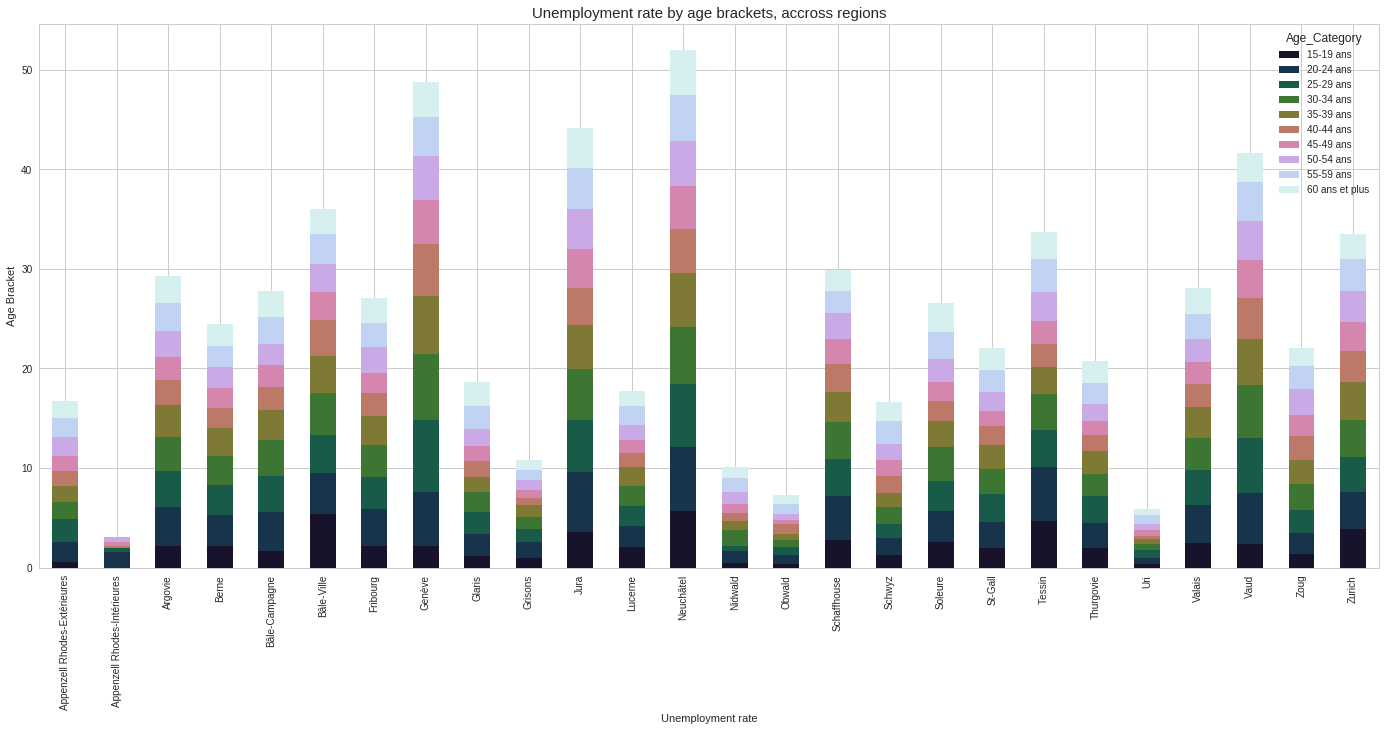

In [103]:
#Plotting and adding info
df_pivoted_age.plot.bar(figsize=(24,10),stacked=True)

plt.title('Unemployment rate by age brackets, accross regions',fontsize=15)
plt.ylabel('Age Bracket')
plt.xlabel('Unemployment rate')
plt.show()

In [104]:
#Plotting and adding info
df_pivoted_age = df_age.reset_index().pivot(index='Age_Category', columns='Canton', values='Unemployement_Rate')
cols = df_pivoted_age.columns.tolist()
cols = [cols[-1]] + cols[:-1]
df_pivoted_age = df_pivoted_age[cols]
brackets = ['15-19 ans', '20-24 ans', '25-29 ans', '30-34 ans', '35-39 ans','40-44 ans', '45-49 ans', '50-54 ans', '55-59 ans', '60 ans et plus']
plt.stackplot(len(cols), (df_pivoted_age.head(len(cols))[brackets]).T)

plt.title('Unemployment rate by age brackets, accross regions',fontsize=15)
plt.ylabel('Age Bracket')
plt.xlabel('Unemployment rate')
plt.show()

KeyError: "['15-19 ans' '20-24 ans' '25-29 ans' '30-34 ans' '35-39 ans' '40-44 ans'\n '45-49 ans' '50-54 ans' '55-59 ans' '60 ans et plus'] not in index"

## Bonus:

Using the map you have just built, and the geographical information contained in it, could you give a *rough estimate* of the difference in unemployment rates between the areas divided by the [RÃ¶stigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben)?